Le but de l’exercice est de prédire le prix moyen d’une maison à Boston, dans  les années 70.Il s'agit d'un problème de regression

**Chargement des données (dataset)**

In [1]:
from sklearn.datasets import load_boston
import pandas as pd

boston_dataset = load_boston()
boston_dataset.DESCR.split("\n")


['.. _boston_dataset:',
 '',
 'Boston house prices dataset',
 '---------------------------',
 '',
 '**Data Set Characteristics:**  ',
 '',
 '    :Number of Instances: 506 ',
 '',
 '    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.',
 '',
 '    :Attribute Information (in order):',
 '        - CRIM     per capita crime rate by town',
 '        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.',
 '        - INDUS    proportion of non-retail business acres per town',
 '        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)',
 '        - NOX      nitric oxides concentration (parts per 10 million)',
 '        - RM       average number of rooms per dwelling',
 '        - AGE      proportion of owner-occupied units built prior to 1940',
 '        - DIS      weighted distances to five Boston employment centres',
 '        - RAD      index of accessibility to radial highways

**Affichage des 10 premiers lignes du dataset**





In [ ]:
df = pd.DataFrame(boston_dataset.data, columns=boston_dataset.feature_names)
df['MEDV'] = boston_dataset.target

df.head(n=10)

CRIM    ZN  INDUS  CHAS    NOX  ...    TAX  PTRATIO       B  LSTAT  MEDV
0  0.00632  18.0   2.31   0.0  0.538  ...  296.0     15.3  396.90   4.98  24.0
1  0.02731   0.0   7.07   0.0  0.469  ...  242.0     17.8  396.90   9.14  21.6
2  0.02729   0.0   7.07   0.0  0.469  ...  242.0     17.8  392.83   4.03  34.7
3  0.03237   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.63   2.94  33.4
4  0.06905   0.0   2.18   0.0  0.458  ...  222.0     18.7  396.90   5.33  36.2
5  0.02985   0.0   2.18   0.0  0.458  ...  222.0     18.7  394.12   5.21  28.7
6  0.08829  12.5   7.87   0.0  0.524  ...  311.0     15.2  395.60  12.43  22.9
7  0.14455  12.5   7.87   0.0  0.524  ...  311.0     15.2  396.90  19.15  27.1
8  0.21124  12.5   7.87   0.0  0.524  ...  311.0     15.2  386.63  29.93  16.5
9  0.17004  12.5   7.87   0.0  0.524  ...  311.0     15.2  386.71  17.10  18.9

[10 rows x 14 columns]

On vérifie s'il n'y pas des valeurs nulles


In [ ]:
df.isnull().sum()

CRIM       0
ZN         0
INDUS      0
CHAS       0
NOX        0
RM         0
AGE        0
DIS        0
RAD        0
TAX        0
PTRATIO    0
B          0
LSTAT      0
MEDV       0
dtype: int64

**Analyse exploratoire des données** 

Analyse du prix



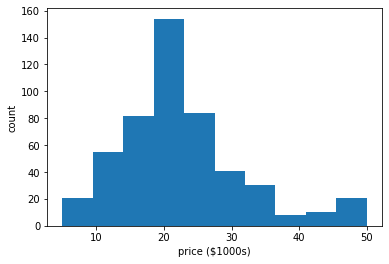

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
plt.hist(boston_dataset.target)
plt.xlabel('price ($1000s)')
plt.ylabel('count');

2. *Nuage de points (Scatter plot)*

In [ ]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import numpy as np

total_items = len(df.columns)
items_per_row = 3
total_rows = math.ceil(total_items / items_per_row)

fig = make_subplots(rows=total_rows, cols=items_per_row, subplot_titles=df.columns)

cur_row = 1
cur_col = 1

for index, column in enumerate(df.columns):
    fig.add_trace(go.Scattergl(x=df[column], 
                            y=df['MEDV'], 
                            mode="markers", 
                            marker=dict(size=3)), 
                  row=cur_row, 
                  col=cur_col)
    
    intercept = np.poly1d(np.polyfit(df[column], df['MEDV'], 1))(np.unique(df[column]))
    
    fig.add_trace(go.Scatter(x=np.unique(df[column]), 
                             y=intercept, 
                             line=dict(color='red', width=1)), 
                  row=cur_row, 
                  col=cur_col)
    
    if cur_col % items_per_row == 0:
        cur_col = 1
        cur_row = cur_row + 1
    else:
        cur_col = cur_col + 1
    

fig.update_layout(height=1000, width=550, showlegend=False)
fig.show()

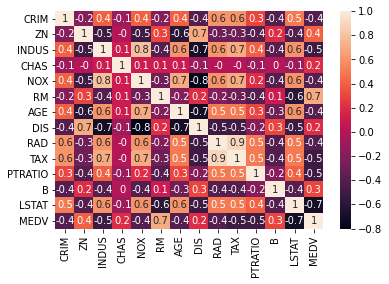

In [ ]:
import seaborn as sns 

#etude de la correlation
matrice_corr = df.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)

Le prix a une forte corrélation avec LSTAT et RM. Cependant il ne faut pas négliger les autres attributs comme CRIM,ZN,INDUS… car leur corrélation sont pas proches de 0

**Pré-traitement des données (Data preprocessing)**

1. Data splitting (70% pour l'apprentissage et 30 pour le test)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.loc[:, df.columns != 'MEDV']
y = df.loc[:, df.columns == 'MEDV']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

2. Normalisation

La normalisation doit uniquement être faite sur les données d'apprentissage (training set)

In [ ]:
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

**Création du modèle**

Le modèle à créer est un MLP avec 2 couches cachées, 128 neurones dans la première couche cachée et 64 neurones dans la deuxième couche cachée. La fonction d'activation est ReLU et la fonction linéaire dans la couche de sortie.

Remarque 


```
Usual loss functions are:

*   "mse" for regression,
*   "categorical_crossentropy" for multiclass classification (when the y array fed to fit is of shape (n,nclasses))
*   "binary_crossentropy" for binary classification (when the model is fed with y array of shape (n,1))

One can also specify additional metrics to be printed during training (correct classification rate here).
```




In [ ]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
# linear sigmoid
model.add(Dense(64, input_shape=(13, ), activation='relu', name='dense_1'))
model.add(Dense(1, activation='linear', name='dense_output'))

model.compile(optimizer='adam', loss='mse', metrics=['mean_absolute_error'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                896       
_________________________________________________________________
dense_output (Dense)         (None, 1)                 65        
Total params: 961
Trainable params: 961
Non-trainable params: 0
_________________________________________________________________


**Phase d'apprentissage du MLP**

1. *Apprentissage* 

Dans cette phase, on va utiliser le dataset d'apprentissage

In [ ]:
history = model.fit(X_train, y_train, epochs=150, validation_split=0.05)


Epoch 1/150
11/11 [==============================] - 1s 19ms/step - loss: 578.9408 - mean_absolute_error: 22.3357 - val_loss: 617.3027 - val_mean_absolute_error: 23.0128
Epoch 2/150
11/11 [==============================] - 0s 5ms/step - loss: 575.8482 - mean_absolute_error: 22.3254 - val_loss: 600.4765 - val_mean_absolute_error: 22.6966
Epoch 3/150
11/11 [==============================] - 0s 5ms/step - loss: 544.6017 - mean_absolute_error: 21.6028 - val_loss: 583.3047 - val_mean_absolute_error: 22.3649
Epoch 4/150
11/11 [==============================] - 0s 5ms/step - loss: 558.1036 - mean_absolute_error: 21.8396 - val_loss: 564.9137 - val_mean_absolute_error: 22.0031
Epoch 5/150
11/11 [==============================] - 0s 24ms/step - loss: 492.7838 - mean_absolute_error: 20.6256 - val_loss: 545.6683 - val_mean_absolute_error: 21.6144
Epoch 6/150
11/11 [==============================] - 0s 5ms/step - loss: 498.1642 - mean_absolute_error: 20.5798 - val_loss: 524.3107 - val_mean_absolute

2. *Affichage de l'erreur*


In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['loss'],
                    name='Apprentissage'))

fig.add_trace(go.Scattergl(y=history.history['val_loss'],
                    name='Validation'))


fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Erreur')

fig.show()

In [ ]:
fig = go.Figure()
fig.add_trace(go.Scattergl(y=history.history['mean_absolute_error'],
                    name='Train'))

fig.add_trace(go.Scattergl(y=history.history['val_mean_absolute_error'],
                    name='Valid'))


fig.update_layout(height=500, width=700,
                  xaxis_title='Epoch',
                  yaxis_title='Mean Absolute Error')

fig.show()

**Evaluation du modèle**

In [ ]:
mse_nn, mae_nn = model.evaluate(X_test, y_test)

print('Mean squared error on test data: ', mse_nn)
print('Mean absolute error on test data: ', mae_nn)

5/5 [==============================] - 0s 2ms/step - loss: 18.0015 - mean_absolute_error: 2.6818
Mean squared error on test data:  18.001522064208984
Mean absolute error on test data:  2.6818299293518066


**Prediction**

In [ ]:
valeur = X_test[:1]
print("l entrée du modèle est : ",valeur)
ynew = model.predict(valeur)
print ("la valeur réelle est", y_test[:1])
print ("la prédiction est ",ynew)

l entrée du modèle est :           CRIM        ZN     INDUS  ...   PTRATIO         B     LSTAT
410  5.174395 -0.497274  1.054194  ...  0.824301 -4.070671 -0.343729

[1 rows x 13 columns]
la valeur réelle est      MEDV
410  15.0
la prédiction est  [[19.080805]]
